# Optimization: Part I

Introduction to optimization

- G. Brammer (29 September 2025)

**Notes for running the demo:** 

- Launch as slides with 

```bash
$ jupyter nbconvert --to slides  week5-optimization.ipynb --post serve --TemplateExporter.extra_template_basedirs=${PWD}/slide_templates/ --template revealx
```

- The interactive bokeh applets use pure-python callbacks.  For now this will only work with `jupyter` running locally and displaying to `localhost` in the browser.  The interactive bokeh plots do not work with cloud-hosted notebooks like [mybinder.org](mybinder.org) or [erda.dk](erda.dk).

In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 5]

np.set_printoptions(precision=3)

from bokeh.themes import Theme
from bokeh.models.widgets.inputs import AutocompleteInput
from bokeh.models.widgets import (PreText, Div, Switch, Dropdown,
                                  RangeSlider, Slider, TextInput,
                                  MultiSelect, MultiChoice,
                                  RadioButtonGroup, Button, Switch,
                                  Toggle)

from bokeh.models import Range1d, Span

# from bokeh.models import Switch, Dropdown
from bokeh.layouts import column, row, layout
from bokeh.plotting import curdoc, figure, show

from bokeh.io import output_notebook

### Enable BokehJS server

Check the host address listed in the browser address bar above and add it in the comma-separated list below if the particular port is not already there.   This usually defaults to something like `localhost:8888/notebooks/week4-nonlinear-equations.ipynb`, but the port can be different, e.g., if you have multiple jupyter sessions running.  The entry needed below is the bit before `/notebooks/`, i.e., `localhost:8888`.

In [2]:
# If the previous cell raised a message, set the line below with the port as indicated
import os

os.environ['BOKEH_ALLOW_WS_ORIGIN'] = 'localhost:8888,localhost:8891,127.0.0.1:8000'
os.environ['BOKEH_ALLOW_WS_ORIGIN'] += ',localhost:8889,localhost:8890'

PORT = 8890
# os.environ['BOKEH_ALLOW_WS_ORIGIN'] = f'localhost:{PORT}'
os.environ['BOKEH_ALLOW_WS_ORIGIN'] = f'localhost:{PORT},127.0.0.1:8000'

show_kws = dict(notebook_handle=True, notebook_url=f'localhost:{PORT}')

# Load this notebook as the bokeh server
output_notebook()

Loading BokehJS ...

In [3]:
# Function plotting range
x = np.linspace(-4,4, 128)

# plot a function
def plot_func(func, deriv, d2=None, title=None):
    plt.plot(x, func(x), label=r'$f(x)$')
    if deriv is not None:
        plt.plot(x, deriv(x), label=r"$f^\prime(x)$")

    if d2 is not None:
        plt.plot(x, d2(x), label=r"$f^{\prime\prime}(x)$")

    plt.hlines(0, *plt.xlim(), color='0.5', linestyle='--', label=r'$y$=0')
    if title is not None:
        plt.title(title)
        
    plt.legend()
    plt.grid()

# Overview

- 6.1 : **Introduction**
- 6.2 : **Existence and Uniqueness**
- 6.3 : **Sensitivity and Conditioning**
- 6.4 : **Optimization in 1D**

Multi-dimensional optimization

- 6.5-6.7 : **Unconstrained/constrained, NLLS**

## Essential topics

- *Objective function*
- *Feasible* set
- *Unimodal function*
- *Golden section search*
- Successive parabolic interpolation
- *Newton's method*
- **Coercive** functions
- **Convex** functions
- Hessian matrix

# Introduction and overview

Many situations give rise to **optimization problems**; some are **unconstrained**, some are **constrained**, meaning that the search for an optimum is restricted by a boundary or some other condition.

The *scalar* function $f(\mathbf{x})$ to be *optimized* is called the **objective function**.

The set **x** over which optimal solutions are sought is called the **feasible set** (with constraints or $S \in \mathbb{R}^n$ without).  In general, **x** is multi-dimensional, but 1D cases are relevant for illustrations and examples.

# Extrema

- $\mathbf{x}^*$ is a *global minimum* if $f(\mathbf{x}^*) < f(\mathbf{x})$ for all feasible $\mathbf{x}$ (point $D$).
- $\mathbf{x}^*$ is a *local minimum* if this is true only locally (point $F$).
    
![Extrema](optimization/extrema_NR_fig10.0.1.png)

# Existence and Uniqueness

A continuous function $f(\mathbf{x})$ is **coercive** if it goes to $+\infty$ with the norm (e.g., abs) of $\mathbf{x}$.

- A **coercive** function has a **global** minimum
- A function on a closed and bounded set has a global minimum

# Convexity

A *feasible set* is **convex** if a line conecting anyt two points lies within the feasible set.

![Convex sets](optimization/convex_set_fig6.3.png)


A *function* is (strictly) **convex** if $f(\mathbf{x})$ on a line connecting two points lies (strictly) below a connecting straight line.

![Convex functions](optimization/convex_func_fig6.4.png)

A *convex function* on a *convex set* has a unique global minimum (if it has a minimum at all).


# Unconstrained optimality

For multi-dimensional $f(\mathbf{x})$, optimization in the direction towards/away from a minimum is given by the **gradient** of $f(\mathbf{x})$, the *vector* consisting of the partial derivatives of $f$ with respect to $x_i$: 

  $\nabla f(\mathbf{x}) = [\partial f/\partial x_1, \partial f/\partial x_2, ..., \partial f/\partial x_n]^T$.
  
The "direction of steepest descent" is $-\nabla f(\mathbf{x})$.

The **Hessian matrix** $H_f$ (Jacobian of the gradient) gives the "metric" of $f(\mathbf{x})$: $H_{ij}(\mathrm{x}) = \partial^2 f / \partial x_i \partial x_j$.

$H$ is symmetric for continuous derivatives:

$H_{ij}(\mathrm{x}) = \partial^2 f / \partial x_i \partial x_j = \partial^2 f / \partial x_j \partial x_i = H_{ji}(\mathrm{x}) $

By Taylor's theorem: $f(x^* + s) = f(x^*) + \nabla f(x^∗)^T s + \frac{1}{2} s^T~H_f(x^*) s + \mathcal{O}(||s^3||)$.

- The Hessian must be **positive definite** for x to be a **minimum**, i.e., $f(x^* + s) > f(x^*)$ for all $s$
- It must be **negative definite** for x to be a **maximum**
- If the Hessian is *indefinite*, then $f$ has a saddle point at $\mathbf{x}$
- If the Hessian is *singular*, $f$ can have, e.g., higher-order minima or maxima

# Building intuition

For example (Ex. 6.2):
> Minimize the surface area of a cylinder with a given volume

This is an example of **constrained optimization**; a function needs to be optimized while another function is kept constant.

> $ V = \pi x_1^2x_2 $

> $ A = 2\pi x_1(x_1+x_2) $

Insert $V$ into $A$:

> $ A = 2\pi x_1(x_1 + \frac{V}{\pi x_1^2} ) $

> $ A = 2\pi (x_1^2 + \frac{V}{\pi x_1}) $

1. Does this have an optimum?
1. Is this optimum a minimum or maximum?

In [4]:
# Define with global variables to count function calls
FUNC_CALLS = 0
DERIV_CALLS = 0

a0, b0 = -3.01, 3.01

def myfunc(x):
    global FUNC_CALLS
    FUNC_CALLS += 1
    
    return np.array(x)**2 - 4*np.sin(x)

def myfunc_deriv(x):
    global DERIV_CALLS
    DERIV_CALLS += 1
    
    return 2*np.array(x) - 4*np.cos(x)

def myfunc_deriv2(x):
    global DERIV_CALLS
    DERIV_CALLS += 1
    
    return 2 + 4*np.sin(x)

# Copies in case we change it later
orig_func = myfunc
orig_deriv = myfunc_deriv
orig_deriv2 = myfunc_deriv2

# Another test function to optimize....
$f(x) = x^2 - 4 \sin(x)$

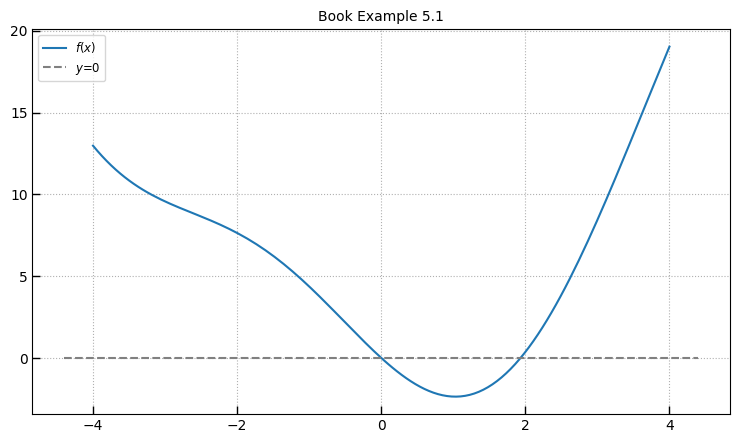

In [5]:
plot_func(myfunc, None, title='Book Example 5.1')

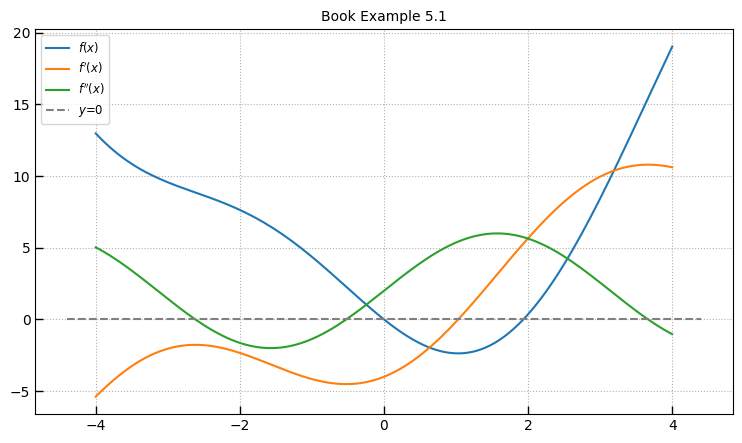

In [6]:
# f(x) = x**2 - 4 sin(x)
plot_func(myfunc, myfunc_deriv, d2=myfunc_deriv2, title='Book Example 5.1')

# Golden section search for minimum in 1-D

**Algorithm 6.1** From Scientific Computing (M.Heath).

Analog to bisection method for finding roots in 1-D:

1. Bracket a target minimum with $a$, $b$
2. Sample $f(x)$ at two points within the bracket
    - $\tau = (\sqrt{5}-1)/2$
    - $x_1 = a + (1-\tau)(b-a)$
    - $x_2 = a + \tau (b-a)$
3. If $f_1 > f_2$, then $x_1 \rightarrow > a$ else $x_2 \rightarrow b$
4. Repeat....

Convergence is linear ($r=1$) with $C=\tau\approx0.618$.

In [7]:
GOLD = (np.sqrt(5)-1)/2 # golden search step size (tau)

def golden_min(func, a, b, tol=1.e-6, n_steps=10000):
    """
    Take a step towards a function minimum 
    """
    x1 = a + (1-GOLD)*(b-a)
    x2 = a + GOLD*(b-a)
    f1, f2 = func(x1), func(x2)
    i = 0

    prev = (a, b, x1, x2, f1, f2)

    while ((b-a) > tol) & (i < n_steps):
        i += 1
        
        prev = (a, b, x1, x2, f1, f2) # all data from the previous step
        
        if f1 > f2:
            a = x1
            x1, f1 = x2, f2
            x2 = a + GOLD*(b-a)
            f2 = func(x2)
        else:
            b = x2
            x2, f2 = x1, f1
            x1 = a + (1-GOLD)*(b-a)
            f1 = func(x1)

    return a, b, x1, x2, f1, f2, i, prev

In [8]:
# Make a bokeh "app" for interactive plotting    
# Awkward packagaging so that can use a pure-python callback
def golden_app(doc):
    global myfunc
    
    def text_label(a, b):
        return f'a={a:8.4e} b={b:8.4e}  dx={(b-a):8.4e}'

    fig = figure(title="golden section", width=800, height=500,
                 background_fill_color='white',
                 active_drag='box_zoom')
    
    fig.xaxis.axis_label = 'x'
    fig.yaxis.axis_label = 'y'
    fig.xaxis.axis_label_text_font_style = "normal"
    fig.yaxis.axis_label_text_font_style = "normal"

    data_line = fig.line(x=x, y=myfunc(x), color='black', alpha=0.5, line_width=2, legend_label='f(x)')
    # init_scatter = fig.scatter([0,0], [0,0], size=10, color='black')
    # step_scatter = fig.scatter([0,0], [0,0], size=10, color='red', alpha=0.8)

    spans = fig.vspan(x=[0, 0], line_color='red', line_alpha=0.5, legend_label='a, b')
    # yroot = fig.hspan(y=[0], line_color='green', line_alpha=0.3, legend_label='midpt')

    steps_vline = fig.vspan(x=[0], line_color='magenta', line_alpha=0.5)
    steps_scatter = fig.scatter([0,0], [0,0], size=10, color='magenta',
                                legend_label='x1, x2',
                                alpha=0.8)
    
    ITEM_HEIGHT = 64
    text_a = TextInput(title='a', value=f'{a0:.2f}', width=70, height=ITEM_HEIGHT)
    text_b = TextInput(title='b', value=f'{b0:.2f}', width=70, height=ITEM_HEIGHT)

    txt = Div(text=text_label(a0, b0), sizing_mode="fixed", width=450, height=ITEM_HEIGHT,
              styles={'font-size': '110%', 'font-family': 'monospace'})
    
    nsteps = Slider(start=0, end=20, value=0, step=1, 
                    title='n_steps', sizing_mode="fixed", width=200, height=ITEM_HEIGHT)
    
    def update_steps():
        """
        Perform n steps of the bisection algorithm and then plot the results
        """
        n_step = nsteps.value
        a0i = float(text_a.value)
        b0i = float(text_b.value)

        # init_scatter.data_source.data = {'x': [a0i, b0i], 'y': myfunc([a0i, b0i])}

        _ = golden_min(myfunc, a0i, b0i, n_steps=n_step, tol=1.e-30)
        ai, bi, x1, x2, f2, x2, i, prev = _
        ai, bi, x1, x2, f1, f2 = prev
        steps_scatter.data_source.data = {'x': [x1, x2], 'y': [f1,f2]}
        
        spans.data_source.data = {'x': [ai, bi]}
        steps_vline.data_source.data = {'x': [x1, x2]}
        
        txt.text = text_label(ai, bi)

    update_steps()
    
    nsteps.on_change('value', lambda attr, old, new: update_steps())
    text_a.on_change('value', lambda attr, old, new: update_steps())
    text_b.on_change('value', lambda attr, old, new: update_steps())
    
    sliders = row(nsteps)
    p = layout([[text_a, text_b, sliders, txt],
                [fig]])

    doc.add_root(p)
    
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 600
                width: 900
            Grid:
                grid_line_dash: [2, 2]
                grid_line_color: lightgray
    """, Loader=yaml.FullLoader))


In [9]:
show(golden_app, **show_kws)

# Newton search

Use a local quadratic approximation to the objective function

$f(x+h) \approx f(x) + f^\prime(x) h + f^{\prime\prime}(x) h^2 / 2$

This has a stationary point at 

$h = -f^\prime(x) / f^{\prime\prime}(x)$

that is not necessarily a minimum!

## Algorithm (**6.2** from Heath)

$x_{k+1} = x_k - f^\prime(x_k) / f^{\prime\prime}(x_k)$


In [10]:
def newton_min(func_deriv, func_deriv2, x0, force_fpp=True, tol=1.e-18, n_steps=10000):
    """
    Take a step towards a function minimum 

    force_fpp : bool
        If True, require second derivative to be positive (using previous)
    """
    i = 0

    fp = func_deriv(x0)
    fpp = func_deriv2(x0)
    h = -1 * fp / fpp
    
    while (np.abs(h) > tol) & (i < n_steps) & (np.abs(fpp) > 1.e-20):
        # print(i, x0, fpp, h)
        i += 1
        x0 += h
        fp, fppi = func_deriv(x0), func_deriv2(x0)
        if (fppi < 0) & (force_fpp):
            pass
        else:
            fpp = fppi
            
        h = -1 * fp / fpp

    return x0, h, fp, fpp

In [11]:
newton_x0 = 0.0

# Make a bokeh "app" for interactive plotting    
# Awkward packagaging so that can use a pure-python callback
def newton_app(doc):
    global myfunc
    
    def text_label(newton_x0, h, fpp):
        return f'xk={newton_x0:8.4e} h={h:8.4e}, f\'\'(x)={fpp:5.1f}'

    fig = figure(title="newton minimization", width=800, height=500,
                 background_fill_color='white',
                 active_drag='box_zoom')
    
    fig.xaxis.axis_label = 'x'
    fig.yaxis.axis_label = 'y'
    fig.xaxis.axis_label_text_font_style = "normal"
    fig.yaxis.axis_label_text_font_style = "normal"

    data_line = fig.line(x=x, y=myfunc(x), color='black', alpha=0.5, line_width=2, legend_label='f(x)')

    newton_line = fig.line(x=x, y=myfunc(x), color='magenta', alpha=0.5, line_width=2, legend_label='f(x+h)')
    h_scatter = fig.scatter([0], [0], size=10, color='magenta',
                               marker='x',
                                alpha=0.8)

    step_scatter = fig.scatter([0], [0], size=10, color='black',
                                legend_label='xk',
                                alpha=0.8)
    
    ITEM_HEIGHT = 64
    text_x0 = TextInput(title='x0', value=f'{newton_x0:.2f}', width=70, height=ITEM_HEIGHT)
    switch = Switch(active=False)

    switch_txt = Div(text="Force f'' > 0: ", sizing_mode="fixed", width=100, height=ITEM_HEIGHT,
              styles={'font-size': '110%', 'font-weight': 'bold'})

    txt = Div(text=text_label(newton_x0, 0., 0), sizing_mode="fixed", width=350, height=ITEM_HEIGHT,
              styles={'font-size': '110%', 'font-family': 'monospace'})
    
    nsteps = Slider(start=0, end=20, value=0, step=1, 
                    title='n_steps', sizing_mode="fixed", width=200, height=ITEM_HEIGHT)
    
    def update_steps():
        """
        Perform n steps of the bisection algorithm and then plot the results
        """
        n_step = nsteps.value
        x0i = float(text_x0.value)
        
        x0k, h, fp, fpp = newton_min(myfunc_deriv, myfunc_deriv2, x0i,
                                    force_fpp=switch.active, 
                                    tol=1.e-18, n_steps=n_step)

        step_scatter.data_source.data = {'x': [x0k], 'y': [myfunc(x0k)]}
        h_scatter.data_source.data = {'x': [x0k+h],
                                        'y': [myfunc(x0k) + fp*h + fpp*h**2/2]}

        newton_line.data_source.data = {'x': x0k+x,
                                        'y': myfunc(x0k) + fp*x + fpp*x**2/2}

        txt.text = text_label(x0k, h, fpp)

    update_steps()
    
    nsteps.on_change('value', lambda attr, old, new: update_steps())
    text_x0.on_change('value', lambda attr, old, new: update_steps())
    switch.on_change('active', lambda attr, old, new: update_steps())
    
    sliders = row(nsteps)
    p = layout([[text_x0, sliders, txt, switch_txt, switch],
                [fig]])

    doc.add_root(p)
    
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 600
                width: 900
            Grid:
                grid_line_dash: [2, 2]
                grid_line_color: lightgray
    """, Loader=yaml.FullLoader))


In [12]:
# Also try x0=3.0, and then the f'' switch to force positive f''
show(newton_app, **show_kws)

# Unconstrained optimization in *N* dimensions

Implement and compare a variety of iteration schemes for unconstrained optimization.

- Steepest Descent (**Algorithm 6.3** from Heath)

![Steepest descent](optimization/steepest_descent.png)


- Conjugate Gradient (**Algorithm 6.6** from Heath)
- Quasi-Newton / BFGS (**Algorithm 6.5** from Heath)
- BFGS with updates on $B_{k+1}\approx H^{-1}$ (algorithm from Numerical Recipes, Press et al.)
  

Finding a **root** in 1, $n$ dimensions (last week) $\Rightarrow$ Finding a **minimum** in 1, $n$ dimensions

### 1-D

$f(x+h) \approx f(x) + f^\prime(x) h + f^{\prime\prime}(x) h^2 / 2$ + ...

$h = -f^\prime(x) / f^{\prime\prime}(x)$ 

### $n$-D

$f(x^* + s) = f(x^*) + \nabla f(x^∗)^T s + \frac{1}{2} s^T~H_f(x^*) s$ + ...

$H_f(\mathrm{x_k})~s_k = -\nabla f(\mathrm{x_k})$ 


## BFGS

Recall, for Broyden updates to the approximation of the Jacobian: 

$B_{k+1} = B_k + (\Delta y_k - B_k \Delta x_k) \Delta x_k^T~/~(\Delta x_k^T \Delta x_k) \approx J_{k+1}$

Now we're trying to build updates to the *Hessian*, $B_{k+1} \approx H_f$ so we want to add two additional requirements:
 - Should be *positive definite* near the minimum we're looking for
 - Should be *symmetric* (continuous derivatives)

This is achieved with

$B_{k+1} = \frac{\Delta y \Delta y^T}{\Delta y^T \Delta x} + B_k - \frac{B_k \Delta x \Delta x^T B_k}{\Delta x^T B_k \Delta x}$

In [13]:
class NonlinearOptimizer:
    """
    Main helper class for non-linear optimization with different iterative steps
    """
    def __init__(self, fx, grad, hess=None, use_hess=False, x0=[0,0], alpha=(-0.05, 1.1), h=1.e-6):
        """
        hess : func
            If provided and `use_hess=True`, initialize $B$ with $H(x_0)$.

        alpha : (float, float)
            Range of $\alpha$ to use for a line search
            
        """
        
        self.fx = fx
        self.grad = grad
        self.xk = np.array(x0)
        self.h = h
        self.ndim = len(x0)
        self.steps = self.xk[:,None]*1
        self.B = np.eye(self.ndim)
        self.Binv = np.eye(self.ndim)

        if use_hess & (hess is not None):
            self.B = hess(self.xk)
            self.Binv = np.linalg.inv(self.B)
            
        self.alpha = alpha
        
        # Initialize conjugate gradient step
        self.evaluate_gradient()
        self.s = -self.gk
        

    def finite_difference_gradient(self):
        """
        Estimate gradient with finite difference rather than an analytical gradient function
        """
        deye = np.eye(2) * self.h / 2
        #gk = (self.fx((self.xk + deye).T) - self.fx(self.xk)) / h
        gk = (self.fx((self.xk + deye).T) - self.fx((self.xk - deye).T)) / self.h
        return gk

    
    def evaluate_gradient(self):
        """
        Wrapper to evaluate the gradient $F^\prime(x_k)$, either with a gradient function or 
        a finite difference approximation
        """
        if self.grad is None:
            self.gk = self.finite_difference_gradient()
        else:
            self.gk = self.grad(self.xk)
        
    
    def steepest_step(self, tol=1.e-6, n_steps=1000, reset=None, verbose=False, line_search=False, **kwargs):
        """
        Step along steepest descent along $s_k = -\nabla(x_k)$ scaled by a golden minimum search.
        """
        self.s = -self.gk
        
        _ = golden_min(self.falpha, *self.alpha, **kwargs)
        ai = _[0]
        if verbose:
            print(f'Step: alpha={ai:.3f}, x={self.xk} next={self.xk+self.s*ai}')

        self.xk = self.xk + self.s*ai
        
        self.evaluate_gradient()
        
        self.steps = np.hstack([self.steps, self.xk[:,None]])

    
    def bfgs_step(self, verbose=False, line_search=False, reset=1000, **kwargs):
        """
        Take a BFGS step
        """
        self.evaluate_gradient()
        Gk = self.gk*1

        if self.steps.shape[1] % (reset*self.ndim) == 0:
            self.B = np.eye(self.ndim)
            
        sk = np.linalg.solve(self.B, -Gk)
        if line_search:
            self.s = sk
            _ = golden_min(self.falpha, *self.alpha, **kwargs)
            ai = _[0]
        else:
            ai = 1.0

        sk *= ai
        
        self.xk = self.xk + sk
        
        self.evaluate_gradient()
        Gk1 = self.gk*1
        
        yk = Gk1 - Gk
        yksk = yk @ sk
        skb = (sk.T @ self.B @ sk)
        if (yksk == 0) | (skb == 0):
            self.Bconverged = self.B
            return None

        db = np.outer(yk, yk) / yksk
        db -= (self.B @ np.outer(sk, sk) @ self.B) / skb
            
        self.B += db
        
        if verbose:
            print(f'BFGS: {self.xk}')

        self.steps = np.hstack([self.steps, self.xk[:,None]])

    
    def inv_bfgs_step(self, verbose=False, line_search=False, reset=None, **kwargs):
        """
        Take a BFGS step but updating the *inverse* of the Hessian, Binv

        B updates comes from Numerical Recipes p. 428
        """
        self.evaluate_gradient()
        Gk = self.gk*1
        
        sk = self.Binv @ -Gk
        if line_search:
            self.s = sk
            _ = golden_min(self.falpha, *self.alpha, **kwargs)
            ai = _[0]
        else:
            ai = 1.0

        sk *= ai
        self.xk = self.xk + sk
        
        self.evaluate_gradient()
        Gk1 = self.gk*1
        
        yk = Gk1 - Gk

        yksk = sk @ yk
        ykb = (yk.T @ self.Binv @ yk)
        if (yksk == 0) | (ykb == 0):
            return None

        db = np.outer(sk, sk) / yksk
        db -= np.outer(self.Binv @ yk, self.Binv @ yk) / ykb

        # Additional term on BFGS from NR, p. 428
        u = sk / (sk @ yk) - (self.Binv @ yk) / ykb
        db += ykb * np.outer(u, u)
        
        self.Binv += db
        
        if verbose:
            print(f'inv BFGS: {self.xk}')

        self.steps = np.hstack([self.steps, self.xk[:,None]])

    
    def conjugate_gradient_step(self, verbose=True, reset=1000, line_search=False, **kwargs):
        """
        Conjugate gradient step
        """
        gk = self.gk*1

        if self.steps.shape[1] % (reset*self.ndim) == 0:
            # Reset step to gradient
            self.s = -gk
            
        gk2 = (gk @ gk)
        if gk2 == 0: # avoid divide by zero 
            return None
            
        _ = golden_min(self.falpha, *self.alpha, **kwargs)
        ai = _[0]
        self.xk = self.xk + self.s*ai

        self.evaluate_gradient()
        gk1 = self.gk*1
        beta = (gk1 @ gk1) / gk2
        self.s = -gk1 + beta*self.s

        if verbose:
            print(f'CG: {self.xk} a:{ai}')

        self.steps = np.hstack([self.steps, self.xk[:,None]])

    
    def falpha(self, alpha):
        """
        Evaluate $F(x_k + \alpha s_k)$ with scalar $\alpha$
        """
        return self.fx((self.xk + alpha*self.s))

    
    def fline(self, alpha):
        """
        Evaluate $F(x_k + \alpha s_k)$ with vector $\alpha$ """
        return self.fx((self.xk + alpha[:,None]*self.s).T)

    
    def fsafe(self, alpha):
        """
        Wrapper around scalar/vector alpha
        """
        try:
            return self.fline(alpha)
        except:
            return self.falpha(alpha)

    
    def log_fsafe(self, alpha):
        """
        $\log_{10} $F(x_k + \alpha s_k)$, e.g., for plotting
        """
        return np.log10(self.fsafe(alpha))
        

In [14]:
# Test function to optimize
x0 = [5,1]
fx = lambda x : 0.5*x[0]**2 + 2.5*x[1]**2
grad = lambda x : np.array([x[0], 5*x[1]])
hess = lambda x : np.array([[1, 0], [0, 5]])

xarr = np.linspace(-8,8,256)

if 1:
    # Rosenbrock "banana"
    ab = 1, 2 # ab = (1, 100) for the "hard" version
    x0 = [-1, 1.8]
    fx = lambda x : (ab[0]-x[0])**2 + ab[1]*(x[1]-x[0]**2)**2
    grad = lambda x : np.array([4*ab[1]*x[0]**3 - 4*ab[1]*x[0]*x[1] + 2*x[0] - 2*ab[0], ab[1]*2*(x[1]-x[0]**2)])
    hess = lambda x : np.array([[12*ab[1]*x[0]**2 - 4*ab[1]*x[1] + 2, -4*ab[1]*x[0]],
                                [-4*ab[1]*x[0], 2*ab[1]]])

xarr = np.linspace(-3,3,1024)+0.01
xg, yg = np.meshgrid(xarr, xarr)
z = fx(np.array([xg, yg]))

# A more complicated non-linear *N*-dim system

The Rosenbrock "banana"

$ f(\mathbf{x}) = (a-x_1)^2 + b(x_2 - x_1^2)^2 $

has a minimum at $\mathbf{x} = [1, 1]$.

As an optimization test case, usually takes $a=1$ and $b=100$, but here we'll make it a bit less extreme with $a=1$, $b=2$.

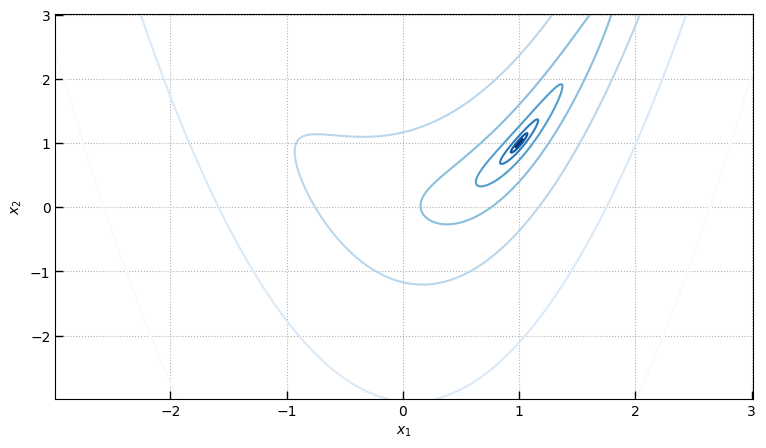

In [15]:
fig, ax = plt.subplots(1,1,)
ax.contour(xg, yg, np.log10(z), levels=np.linspace(-3,2,8), cmap=plt.cm.Blues_r)
ax.grid(); ax.set_xlabel(r'$x_1$'); ax.set_ylabel(r'$x_2$');  

# Use a canned routine:

```python
from scipy.optimize import minimize
minimize?
...
method : str or callable, optional
    Type of solver.  Should be one of
        ...
        - 'CG'          :ref:`(see here) <optimize.minimize-cg>`
        - 'BFGS'        :ref:`(see here) <optimize.minimize-bfgs>`
        - 'Newton-CG'   :ref:`(see here) <optimize.minimize-newtoncg>`
        ...
```

In [16]:
# Using a canned routine
from scipy.optimize import minimize
minimize(fx, jac=grad, x0=x0, method='BFGS')

      fun: 1.3391177888062103e-12
 hess_inv: array([[0.472, 0.925],
       [0.925, 2.051]])
      jac: array([-2.668e-06,  2.193e-06])
  message: 'Optimization terminated successfully.'
     nfev: 19
      nit: 14
     njev: 19
   status: 0
  success: True
        x: array([1., 1.])

In [17]:
x0s = '-1.0 2.5'

x0f = np.cast[float](x0s.split())

from bokeh.palettes import Blues as pal

alpha_range = (-0.05, 1.1)

# Make a bokeh "app" for interactive plotting    
# Awkward packagaging so that can use a pure-python callback
def optimize_2d_app(doc):
    global myfunc
    
    def text_label(xk):
        return f'xk = {xk[0]-1:8.4e} {xk[1]-1:8.4e}'

    from bokeh.palettes import Blues as pal
    from bokeh.models import CustomJS, Dropdown, RadioButtonGroup
    
    fig = figure(title="N-d minimization", width=800, height=500,
                 background_fill_color='white',
                 active_drag='box_zoom')
    
    fig.xaxis.axis_label = 'x'
    fig.yaxis.axis_label = 'y'
    fig.xaxis.axis_label_text_font_style = "normal"
    fig.yaxis.axis_label_text_font_style = "normal"
    fig.x_range = Range1d(-3, 3)
    fig.y_range = Range1d(-3, 3)


    levels = np.linspace(np.log10(z).min(), np.log10(z).max(), 10)
    contour_renderer = fig.contour(xg, yg, np.log10(z), levels,
                                   fill_color=pal, line_color="black")
    
    ITEM_HEIGHT = 64
    
    data_line = fig.line(x=[0], y=[0], color='red', alpha=0.8, line_width=2, legend_label='Steps')
    x0_scatter = fig.scatter(x=[x0f[0]], y=[x0f[1]], color='black', alpha=0.8, line_width=2, legend_label='x0')
    
    LABELS = ["1: Steepest descent", "2: Conjugate gradient", "3: BFGS", "4: Inv BFGS"]
    
    buttons = RadioButtonGroup(labels=LABELS, active=0, width=500, height=int(ITEM_HEIGHT*0.5))
    
    switch = Switch(active=False)
    switch_txt = Div(text="BFGS αΔx", sizing_mode="fixed", width=100, height=int(ITEM_HEIGHT*0.5),
              styles={'font-size': '110%', 'font-weight': 'bold'})

    hswitch = Switch(active=False)
    hswitch_txt = Div(text="B0 = H(x0)", sizing_mode="fixed", width=100, height=int(ITEM_HEIGHT*0.5),
              styles={'font-size': '110%', 'font-weight': 'bold'})

    text_x0 = TextInput(title='x0', value=x0s, width=70, height=ITEM_HEIGHT)
    
    txt = Div(text="Result: ", sizing_mode="fixed", width=250, height=ITEM_HEIGHT,
              styles={'font-size': '110%', 'font-family': 'monospace'})
    
    nsteps = Slider(start=0, end=40, value=0, step=1, 
                    title='n_steps', sizing_mode="fixed", width=300, height=ITEM_HEIGHT)

    def update_steps():
        x0 = np.cast[float](text_x0.value.split())
        LS = NonlinearOptimizer(fx, grad, hess=hess, x0=x0, alpha=alpha_range, use_hess=hswitch.active)
        
        if buttons.active == 0:
            step_func = LS.steepest_step
        elif buttons.active == 1:
            step_func = LS.conjugate_gradient_step
        elif buttons.active == 3:
            step_func = LS.inv_bfgs_step
        else:
            step_func = LS.bfgs_step
            
        for iter in range(nsteps.value):
            step_func(verbose=False, reset=8000, line_search=switch.active)

        x0_scatter.data_source.data = {'x': [x0[0]], 'y': [x0[1]]}
        data_line.data_source.data = {'x': LS.steps[0], 'y': LS.steps[1]}
        txt.text = text_label(LS.xk)
        
        # plt.plot(*LS.steps, marker='.', color='k', alpha=0.1)
        
    nsteps.on_change('value', lambda attr, old, new: update_steps())
    text_x0.on_change('value', lambda attr, old, new: update_steps())
    buttons.on_change('active', lambda attr, old, new: update_steps())
    switch.on_change('active', lambda attr, old, new: update_steps())
    hswitch.on_change('active', lambda attr, old, new: update_steps())

    p = layout([[buttons, switch_txt, switch, hswitch_txt, hswitch], [text_x0, nsteps, txt],
                    [fig]])
    
    doc.add_root(p)
    
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 600
                width: 900
            Grid:
                grid_line_dash: [2, 2]
                grid_line_color: lightgray
    """, Loader=yaml.FullLoader))


In [18]:
alpha_range = (-0.01, 1.2)
show(optimize_2d_app, **show_kws)

## Finding optimal $\Delta x_k = \alpha s_k$ 

Line searches along the $s_k$ direction suggested by the BFGS iteration suggest that the optimal step size may not be the full length of $s_k$ estimated by the iterative step.  Here look what this step size might be relative to the nominal step with $\alpha = 1$.

In [19]:
NSTEPS = 10
cmap = plt.cm.Spectral
colors = [cmap(i) for i in np.linspace(0, 1, NSTEPS+1)]
agrid = np.linspace(*(-0.01,1.2),256)

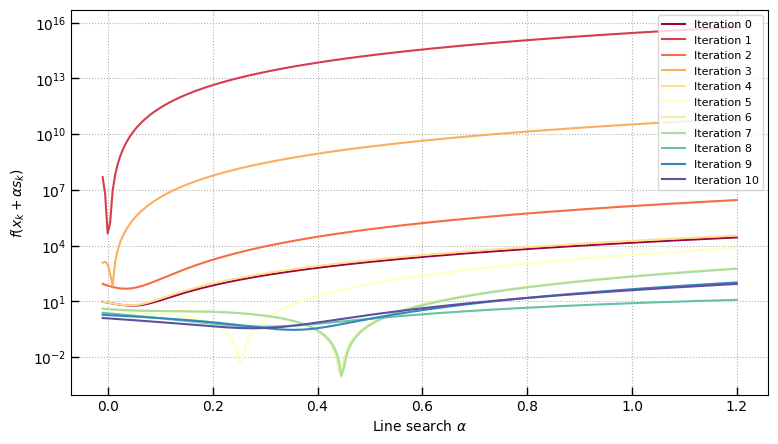

In [20]:
# Line searches
LS = NonlinearOptimizer(fx, grad, x0=[-1, 2.5], alpha=(-0.01,1.2))
LS.s = -LS.gk

fig, ax = plt.subplots(1,1)
ax.plot(agrid, LS.fline(agrid), color=colors[0] , label=f'Iteration {0}')

for it in range(NSTEPS):
    LS.bfgs_step(verbose=False, line_search=False)
    LS.s = -LS.gk    
    ax.plot(agrid, LS.fline(agrid), color=colors[it+1] , label=f'Iteration {it+1}')

ax.grid(); ax.legend(fontsize=8, loc='upper right'); ax.set_xlabel(r'Line search $\alpha$'); ax.set_ylabel(r'$f(x_k + \alpha s_k)$')
_ = ax.semilogy()

### Including the adjusted step

Do the same thing but now where the "optimal" step with $\alpha \ne 1$ is taken at each iteration.

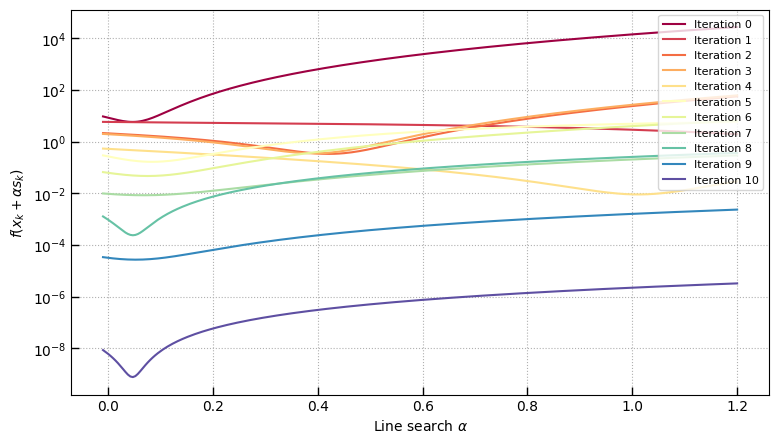

In [21]:
LS = NonlinearOptimizer(fx, grad, x0=[-1, 2.5], alpha=(-0.01,1.2))
LS.s = -LS.gk

fig, ax = plt.subplots(1,1)
ax.plot(agrid, LS.fline(agrid), color=colors[0] , label=f'Iteration {0}')

for it in range(NSTEPS):
    LS.bfgs_step(verbose=False, line_search=True) # Do the line search at each step
    LS.s = -LS.gk    
    ax.plot(agrid, LS.fline(agrid), color=colors[it+1] , label=f'Iteration {it+1}')

ax.grid(); ax.legend(fontsize=8, loc='upper right'); ax.set_xlabel(r'Line search $\alpha$'); ax.set_ylabel(r'$f(x_k + \alpha s_k)$')
_ = ax.semilogy()

In [22]:
# With alpha switch to make dx_k = alpha_k * sk
show(optimize_2d_app, **show_kws)

# Approximating the Hessian

The BFGS method builds up an approximation of the Hessian matrix $H$, starting from $B_0 \equiv I$.

Here just show how $B_0 = I \rightarrow B_k \approx H(x^*)$ as the iteration proceeds and $x_k \rightarrow x^*$.


In [23]:
def printb(B):
    res = f'|{B[0,0]:8.3f} {B[0,1]:8.3f}|'
    res += '\n'+f'|{B[1,0]:8.3f} {B[1,1]:8.3f}|'
    print(res)

In [24]:
LS = NonlinearOptimizer(fx, grad, hess=hess, use_hess=False, x0=[1.2, 1.2], alpha=(-0.01,1.2))
print(f'B0 = I:'); printb(LS.B)
for j in range(3):
    for i in range(10): LS.bfgs_step()
    print(f'\nB(xk) at step {(j+1)*10}:'); printb(LS.B)
    
print('\nTrue H(x*):'); printb(hess([1,1]))

B0 = I:
|   1.000    0.000|
|   0.000    1.000|

B(xk) at step 10:
| 241.397  -58.187|
| -58.187   16.879|

B(xk) at step 20:
|  18.354   -8.058|
|  -8.058    4.010|

B(xk) at step 30:
|  18.061   -8.022|
|  -8.022    4.007|

True H(x*):
|  18.000   -8.000|
|  -8.000    4.000|
